In [1]:
# import zipfile

# f = zipfile.ZipFile("DRD_Split.zip",'r') # 压缩文件在jupyter中的位置
# for file in f.namelist():
#     f.extract(file,"DRD_Split_Cloud")               # 解压到的位置
# f.close()

In [2]:
# !pip install scipy

In [3]:
# # !pip install tensorflow-addons==0.18.0
# # !pip install scikit-learn
# !pip install seaborn


In [4]:
from tensorflow_addons.metrics import F1Score

In [5]:
import os
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization,Activation, concatenate, DepthwiseConv2D, Multiply,Dropout
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D,Flatten, Layer,BatchNormalization, Add,Reshape,AveragePooling2D

from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam


from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt



In [8]:
input_shape = (224, 224, 3)

train_dir = '/root/DRD_Split_Cloud/DRD_Split/train'
test_dir = '/root/DRD_Split_Cloud/DRD_Split/test'

batch_size = 8
num_classes = 2
# filter_factor = 8

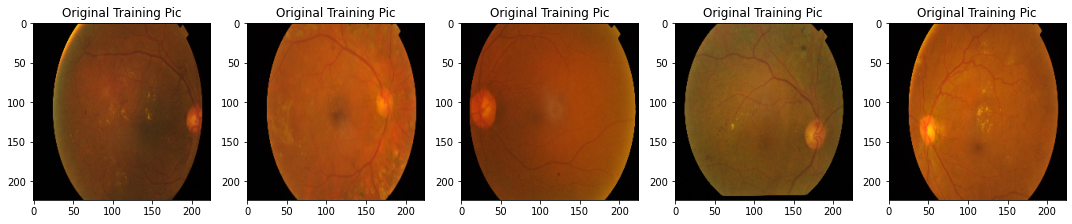

In [9]:
train_diabetic = '/root/DRD_Split_Cloud/DRD_Split/train/diabetic'

#Show the import original image
train_img_files = os.listdir(train_diabetic)
# test_img_files = os.listdir(test_dir)
# val_img_files = os.listdir(val_dir)

show_num = 5

plt.figure(figsize = (15, 5))

for i in range(show_num):
    
    img_path = os.path.join(train_diabetic, train_img_files[i])
    img = plt.imread(img_path)
    plt.subplot(1, show_num, i + 1)
    plt.imshow(img)
    plt.axis('on')
    plt.title("Original Training Pic")
    
plt.tight_layout()
plt.show()


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.13,  # Specify the validation split here
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 'validation' subset for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2708 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


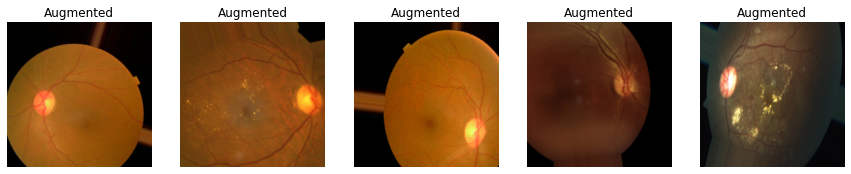

In [11]:
#To show the augmented pictures, after rotation, zoom in, rescale etc

# import scipy

# Extract a batch of images from the train_generator
sample_images, sample_labels = next(train_generator)

plt.figure(figsize = (15, 5))

# Show the original images from the batch
num_images_to_show = 5  # Show three images
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sample_images[i-1])
    plt.title("Augmented")
    plt.axis('off')

In [14]:
filter_factor = 4
def branch_and_skip(input_shape):
    input_shape = Input(input_shape)
    Original = input_shape
    
    
    #Give three branches, and let the tensor be calculated in each branch
    B1 = Conv2D(16//filter_factor, (1, 1), activation = 'relu', padding = 'same')(input_shape)
    B1 = Conv2D(32//filter_factor, (1, 1), activation = 'relu', padding = 'same')(B1)

    
    
    B2 = Conv2D(32//filter_factor, (3, 3), activation = 'relu', padding = 'same')(input_shape)
    B2 = Conv2D(64//filter_factor, (3, 3), activation = 'relu', padding = 'same')(B2)


    B3 = Conv2D(128//filter_factor, (1, 1), activation = 'relu', padding = 'same')(input_shape)
    B3 = Conv2D(256//filter_factor, (1, 1), activation = 'relu', padding = 'same')(B3)
    B3 = Conv2D(384//filter_factor, (1, 1), activation = 'relu', padding = 'same')(B3)

    x = concatenate([B1, B2, B3, Original], axis = -1)
    x = Conv2D(1024//filter_factor, (1, 1), activation = 'relu', padding = 'same')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation = 'softmax')(x)
    return Model(input_shape, outputs)

In [15]:
ensemble_model = branch_and_skip(input_shape)
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 224, 224, 32  128         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 4)  16          ['input_2[0][0]']                
                                                                                              

2023-12-09 16:40:55.841537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 16:40:56.397179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6


In [17]:
lr = 0.001
Optimizer = Adam(learning_rate = lr)

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import backend as K


ensemble_model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=[
        'accuracy', 
        Precision(), 
        Recall(), 
        AUC(), 
        F1Score(num_classes=2, average = 'micro')
    ]
)
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,
                                verbose = 1)
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=20, verbose=1, 
                               restore_best_weights=True)


In [18]:
history = ensemble_model.fit(train_generator, epochs = 100, validation_data=(validation_generator), callbacks = [lr_reduction, early_stopping])

Epoch 1/100


2023-12-09 16:41:22.708537: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-09 16:41:24.103258: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


339/339 [==============================] - 34s 91ms/step - loss: 0.6305 - accuracy: 0.6137 - precision: 0.6137 - recall: 0.6137 - auc: 0.6798 - f1_score: 0.6137 - val_loss: 0.5131 - val_accuracy: 0.7129 - val_precision: 0.7129 - val_recall: 0.7129 - val_auc: 0.8253 - val_f1_score: 0.7129 - lr: 0.0010
Epoch 2/100
339/339 [==============================] - 30s 88ms/step - loss: 0.3990 - accuracy: 0.8235 - precision: 0.8235 - recall: 0.8235 - auc: 0.9054 - f1_score: 0.8235 - val_loss: 0.3010 - val_accuracy: 0.8762 - val_precision: 0.8762 - val_recall: 0.8762 - val_auc: 0.9537 - val_f1_score: 0.8762 - lr: 0.0010
Epoch 3/100
339/339 [==============================] - 30s 88ms/step - loss: 0.2838 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9520 - f1_score: 0.9036 - val_loss: 0.2156 - val_accuracy: 0.9257 - val_precision: 0.9257 - val_recall: 0.9257 - val_auc: 0.9774 - val_f1_score: 0.9257 - lr: 0.0010
Epoch 4/100
339/339 [==============================] - 30s 89ms/step -

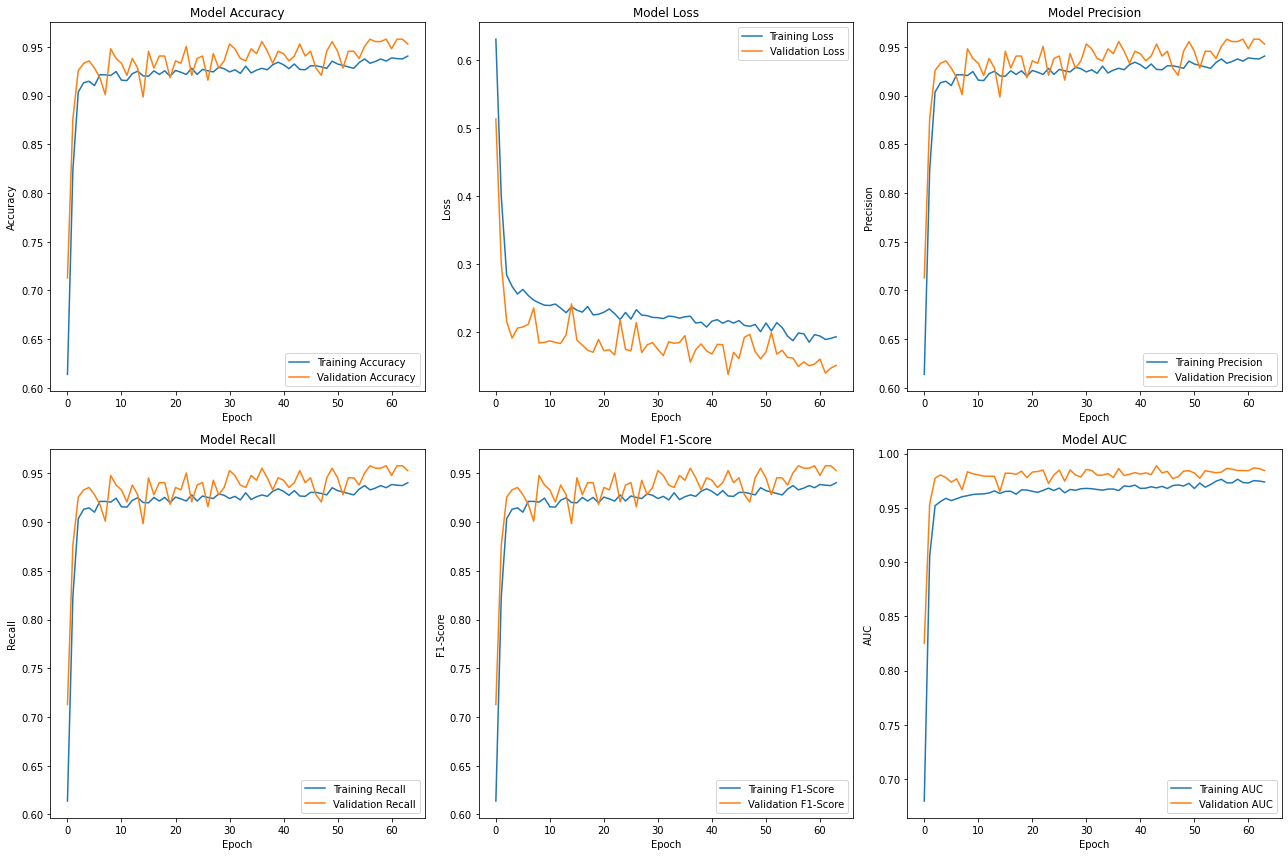

In [19]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training Precision', 'Validation Precision'], loc='lower right')


plt.subplot(2, 3, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(['Training F1-Score', 'Validation F1-Score'], loc='lower right')

plt.subplot(2, 3, 6)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'], loc='lower right')

plt.tight_layout()
plt.show()

17/17 [==============================] - 1s 35ms/step


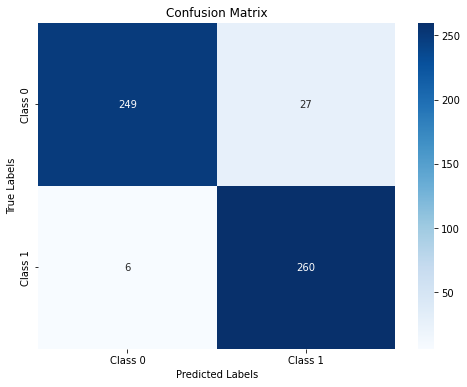

In [22]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 收集图像和真实标签
all_images, all_true_labels = zip(*[next(test_generator) for _ in range(test_generator.samples // test_generator.batch_size)])
all_images = np.concatenate(all_images)
all_true_labels = np.argmax(np.concatenate(all_true_labels), axis=1)

# 进行预测并获取预测标签
predictions = ensemble_model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# 生成并绘制混淆矩阵
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [23]:
from sklearn.metrics import f1_score


# 计算F1-Score
f1 = f1_score(all_true_labels, predicted_labels, average='macro')

print("F1-Score:", f1)


f1_each_class = f1_score(all_true_labels, predicted_labels, average=None)
print("F1-Score for each class:", f1_each_class)


F1-Score: 0.9390893023160777
F1-Score for each class: [0.93785311 0.9403255 ]


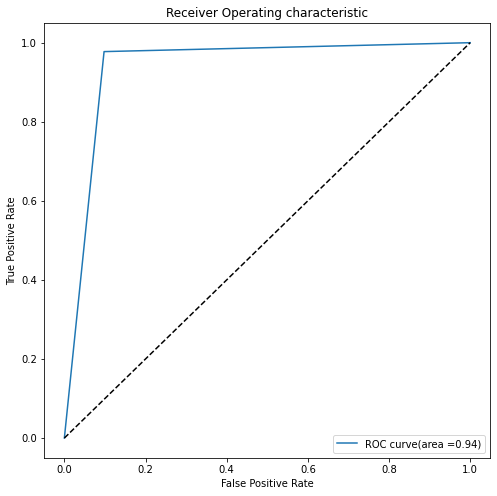

In [24]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(all_true_labels, predicted_labels)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [25]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.9774436090225563
specificity: 0.9021739130434783


17/17 [==============================] - 1s 35ms/step


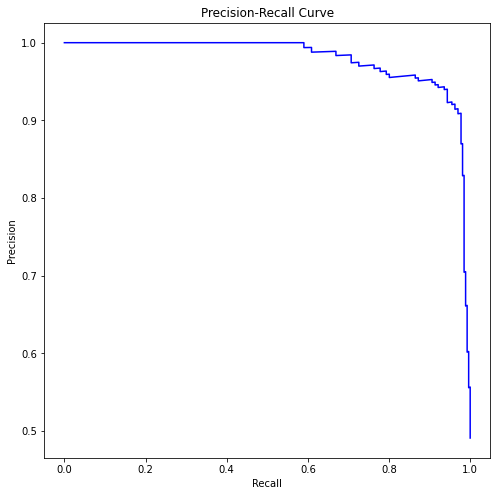

In [26]:
from sklearn.metrics import precision_recall_curve

# 计算预测概率
ensemble_pred_probs = ensemble_model.predict(all_images)

# 获取预测正类的概率
# 假设是二分类问题，并且正类是第二个类别
positive_class_probs = ensemble_pred_probs[:, 1]

# 计算 Precision 和 Recall
precision, recall, thresholds = precision_recall_curve(all_true_labels, positive_class_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [27]:
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)
print('Test F1 Score:', test_f1_score)

69/69 [==============================] - 1s 19ms/step - loss: 0.1867 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9768 - f1_score: 0.9364
Test loss: 0.18671958148479462
Test accuracy: 0.9363636374473572
Test precision: 0.9363636374473572
Test recall: 0.9363636374473572
Test AUC: 0.9768083095550537
Test F1 Score: 0.9363636374473572


In [28]:
from sklearn.metrics import classification_report

# 使用模型对验证集进行预测，获取预测概率
y_pred_probs = ensemble_model.predict(all_images)

# 将预测概率转换为类别标签
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 假设 y_val 是真实标签，并且也是类别标签形式
# 现在您可以生成分类报告
report = classification_report(all_true_labels, y_pred_labels)
print(report)


17/17 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       276
           1       0.91      0.98      0.94       266

    accuracy                           0.94       542
   macro avg       0.94      0.94      0.94       542
weighted avg       0.94      0.94      0.94       542



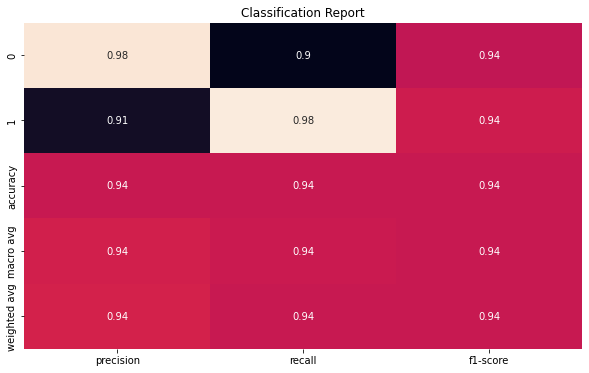

In [29]:
import pandas as pd


# Generate a classification report (replace this with your actual data)
report = classification_report(all_true_labels, y_pred_labels, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Drop the 'support' column, as it's not suitable for the heatmap
report_df = report_df.drop(columns=['support'])

# Draw the heatmap with the default colormap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cbar=False)
plt.title("Classification Report")
plt.show()

In [31]:
#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

del branch_and_skip


from numba import cuda

cuda.select_device(0)
cuda.close()